## Quickstart Guide to the pwlfit Package

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
  import pwlfit
except ImportError:
  %pip install pwlfit

In [3]:
from pwlfit.util import read_sample_data
from pwlfit.grid import Grid
from pwlfit.driver import PWLinearFitConfig, PWLinearFitter

## Fits to Sample Data

This package performs piece-wise linear fits to noisy data $y_k = y(x_k)$ where each measurement $y_k$ has an associatd inverse-variance weight $w_k = \sigma(y_k)^{-2}$.  We optimize for fitting many different $(y_k, w_k)$ all sampled at the same points $x_k$, so the steps are:
 - define the $x_k$ values and the grid of possible knot (segment boundary) locations,
 - configure a fitter to use
 - fit each pair of arrays $(y_k, w_k)$

Below, we demonstrate fitting 3 sample datasets that are included in this package.

### Sample A

This sample data is generated from a piecewise linear model with 10 knots and noise added:

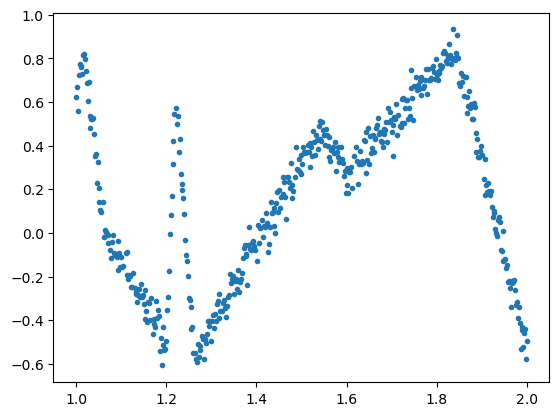

In [4]:
xA, yA, ivarA = read_sample_data('A')
plt.plot(xA, yA, '.');

Define a grid of 100 equally spaced possible locations for the knots. The fitter finds a subset of these knots that describe the data.

In [5]:
gridA = Grid(xA, ngrid=100)

Initialize a fitter with the grid and a default configuration:

In [6]:
fitterA = PWLinearFitter(gridA)

Run the fit. This can be repeated for different $(y_k, w_k)$.

In [7]:
fitA = fitterA(yA, ivarA)

Final fit uses 10 knots
PWLinearFitter completed in 22.6 ms


The fitter returns a `FitResult` object (try `help(fit)`) and also stores more details as attributes.

Superimpose the fit to see the fit quality and knot locations:

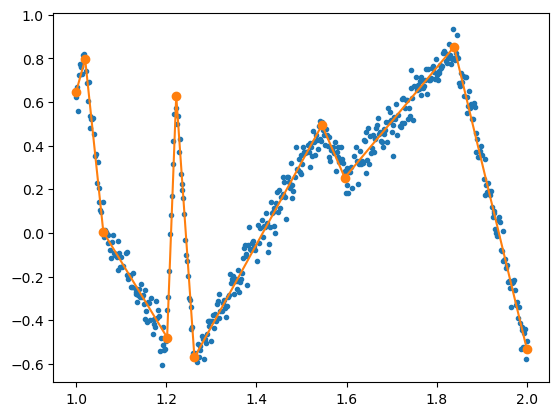

In [8]:
plt.plot(xA, yA, '.')
plt.plot(fitA.xknots, fitA.yknots, 'o-');

### Sample B

This sample data is generated from a non-linear function with noise added:

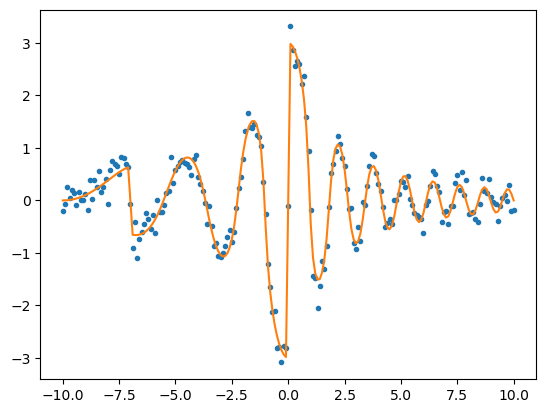

In [9]:
xB, yB, ivarB = read_sample_data('B')
plt.plot(xB, yB, '.');

F = lambda x: np.arcsinh(np.sinc(x + 0.05 * x ** 2) / 0.1) * np.sign(x) * np.sign(x + 7)
yBsmooth = F(xB)
plt.plot(xB, yBsmooth, '-');

Define a grid of 100 equally spaced possible locations for the knots and use the default fit configuration:

In [10]:
gridB = Grid(xB, ngrid=100)

fitterB = PWLinearFitter(gridB)

Final fit uses 34 knots
PWLinearFitter completed in 19.6 ms


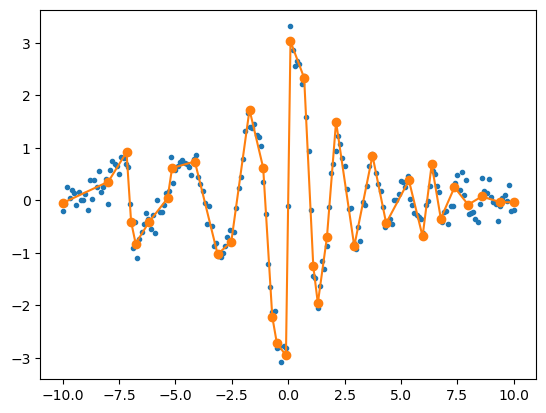

In [12]:
fitB = fitterB(yB, ivarB)

plt.plot(xB, yB, '.')
plt.plot(fitB.xknots, fitB.yknots, 'o-');

You will typically need to adjust the fit configuration to get the desired results for your data, trading off speed, accuracy and complexity. For example, to reduce the number of knots used:

In [18]:
configB2 = PWLinearFitConfig()
print(f'Default penalty: {configB2.discontinuous.penalty}')
configB2.discontinuous.penalty = 5

fitterB2 = PWLinearFitter(gridB, config=configB2)
fitB2 = fitterB2(yB, ivarB)

Default penalty: 2
Final fit uses 24 knots
PWLinearFitter completed in 19.1 ms


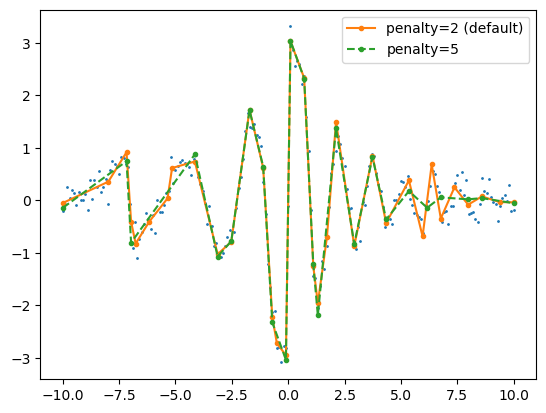

In [19]:
plt.plot(xB, yB, '.', ms=2)
plt.plot(fitB.xknots, fitB.yknots, '.-', label='penalty=2 (default)')
plt.plot(fitB2.xknots, fitB2.yknots, '.--', label='penalty=5')
plt.legend();

### Sample C

The final sample is a noisy spectrum (flux versus wavelength) of a distant quasar recorded by [DESI](desi.lbl.gov):

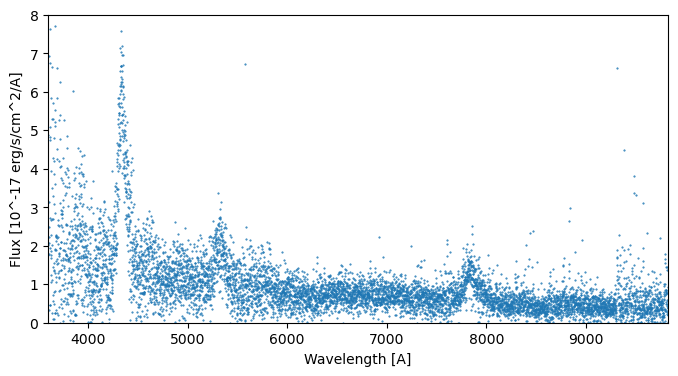

In [25]:
xC, yC, ivarC = read_sample_data('C')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(xC, yC, '.', ms=1)
ax.set(ylim=(0, 8), xlabel='Wavelength [A]', xlim=(xC[0],xC[-1]), ylabel='Flux [10^-17 erg/s/cm^2/A]');

Since the same source observed at different distances, measured by a "redshift" $z > 0$, is stretched by a multiplicative factor $1+z$, it is convenient to used a grid of possible knot locations that is equally spaced in log wavelength:

In [29]:
gridC = Grid(xC, ngrid=2000, transform='log')

Since DESI spectra have about 8000 measurements, we use 2000 possible knot locations and it takes longer to find a good subset of knots to use for a piecewise linear fit. However, we can accelerate this process with the observation that most of the spectrum is relatively smooth ("continuum") but there are a small number of regions with relatively narrow features ("emission" and "absorption"). We can configure the fitter to take advantage of this structure:

In [30]:
configC = PWLinearFitConfig()
configC.options.find_regions = True

fitterC = PWLinearFitter(gridC, config=configC)

fitC = fitterC(yC, ivarC)

Found 3 regions with median smoothed chisq 1.066
Final fit uses 20 knots
PWLinearFitter completed in 16.9 ms


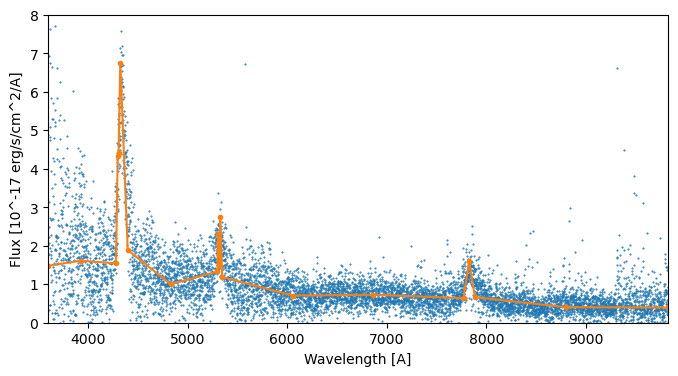

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(xC, yC, '.', ms=1)
ax.plot(fitC.xknots, fitC.yknots, '.-')
ax.set(ylim=(0, 8), xlabel='Wavelength [A]', xlim=(xC[0],xC[-1]), ylabel='Flux [10^-17 erg/s/cm^2/A]');